In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, draw, show, ion
import matplotlib.image as mpimg
import cv2
import scipy.io
from tqdm import tqdm

# from scipy.stats import ortho_group
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
from LDMIBSS import *
from numba import njit
import warnings
warnings.filterwarnings("ignore")
np.random.seed(250)

In [2]:
def Subplot_RGB_images(I, imsize = [3240, 4320], height = 15, width = 15, title = ''):
    n_images = I.shape[0]
    Im = [I[i,:].reshape(imsize[0],imsize[1],3) for i in range(I.shape[0])]
    fig, ax = plt.subplots(1,n_images, figsize = (25,50))
    fig.suptitle(title)
    fig.set_figheight(height)
    fig.set_figwidth(width)   
    for i in range(n_images):
        ax[i].imshow(Im[i])
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)
    plt.subplots_adjust(right=0.97,\
                    left=0.03,\
                    bottom=0.03,\
                    top=0.97,\
                    wspace=0.1,\
                    hspace=0.1)
    plt.draw()    

In [3]:
os.chdir("..")
os.chdir("./NumericalExperiments/ImageSeparation")
image_paths = 'TestImages'
images = []
for im_dir in os.listdir(image_paths):
    try:
        images.append(mpimg.imread(os.path.join(image_paths,im_dir)))
    except:
        pass
images = np.array(images)

In [4]:
small_images = np.zeros((images.shape[0],324* 432* 3))
small_to_large_image_size_ratio = 0.1
for i in range(images.shape[0]):
    small_img = cv2.resize(images[i], # original image
                           (0,0), # set fx and fy, not the final size
                           fx=small_to_large_image_size_ratio, 
                           fy=small_to_large_image_size_ratio, 
                           interpolation=cv2.INTER_NEAREST)
    if small_img.shape[0] == 302:
        small_img = cv2.resize(small_img, (0,0), fx = 432/403, fy = 324/302)
    print(small_img.shape)
    small_images[i] = small_img.reshape(-1,)/255

small_images.shape

(324, 432, 3)
(324, 432, 3)
(324, 432, 3)
(324, 432, 3)


(4, 419904)

<IPython.core.display.Math object>

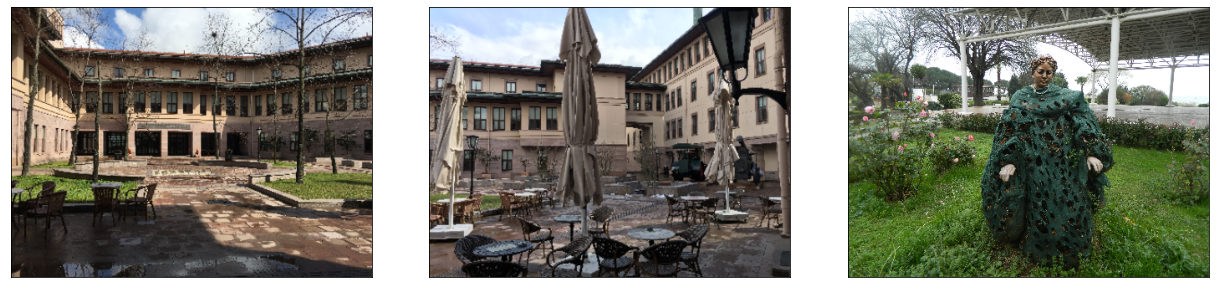

In [5]:
S = small_images[[2,0,1]]
Subplot_RGB_images(S, imsize = [324,432], height = 4, width = 18)
display_matrix(np.corrcoef(S))
# plt.savefig('Original_Images.pdf', format = 'pdf', dpi = 1500)

In [6]:
np.random.seed(50)
NumberofMixtures = 5
NumberofSources = 3
INPUT_STD = 0.28
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for M in range(A.shape[0]):
    stdx = np.std(X[M,:])
    A[M,:] = A[M,:]/stdx * INPUT_STD
    
SNR=40
# A = np.abs(A)
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp

print(20*np.log10(np.std(Xn)/np.std(Noisecomp)))

X_ = ZeroOneNormalizeColumns(X.T).T
print('The following is the mixture matrix')
display_matrix(A)

41.122659361820595
The following is the mixture matrix


<IPython.core.display.Math object>

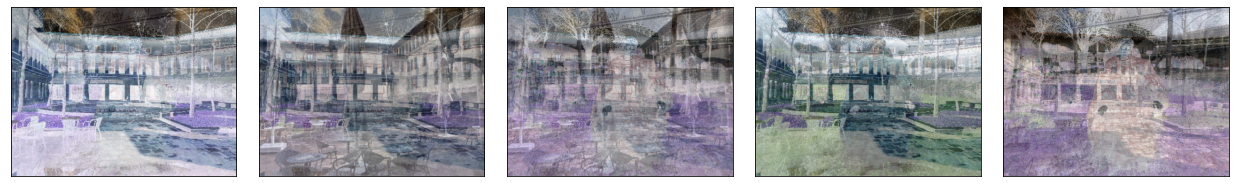

In [7]:
Subplot_RGB_images(X_, imsize = [324,432], height = 3, width = 18)
# plt.savefig('Mixture_Images.pdf', format = 'pdf', dpi = 1500)

# LDMIBSS

In [8]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 2000
model = MinibatchLDMIBSS(s_dim = s_dim, x_dim = x_dim,
                     set_ground_truth = True, S = S, A = A)

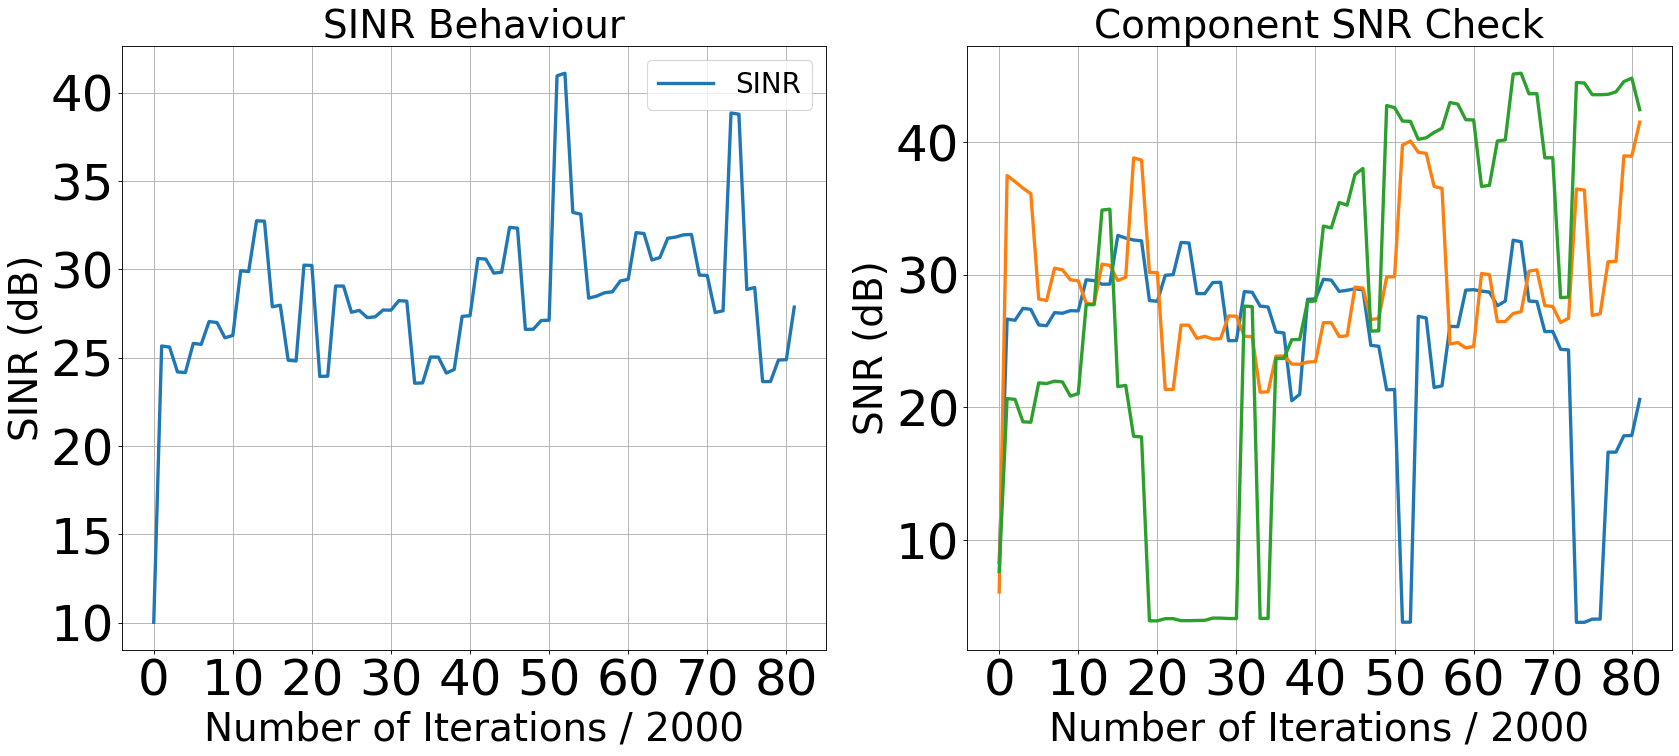

100%|██████████| 2000/2000 [00:04<00:00, 410.42it/s]


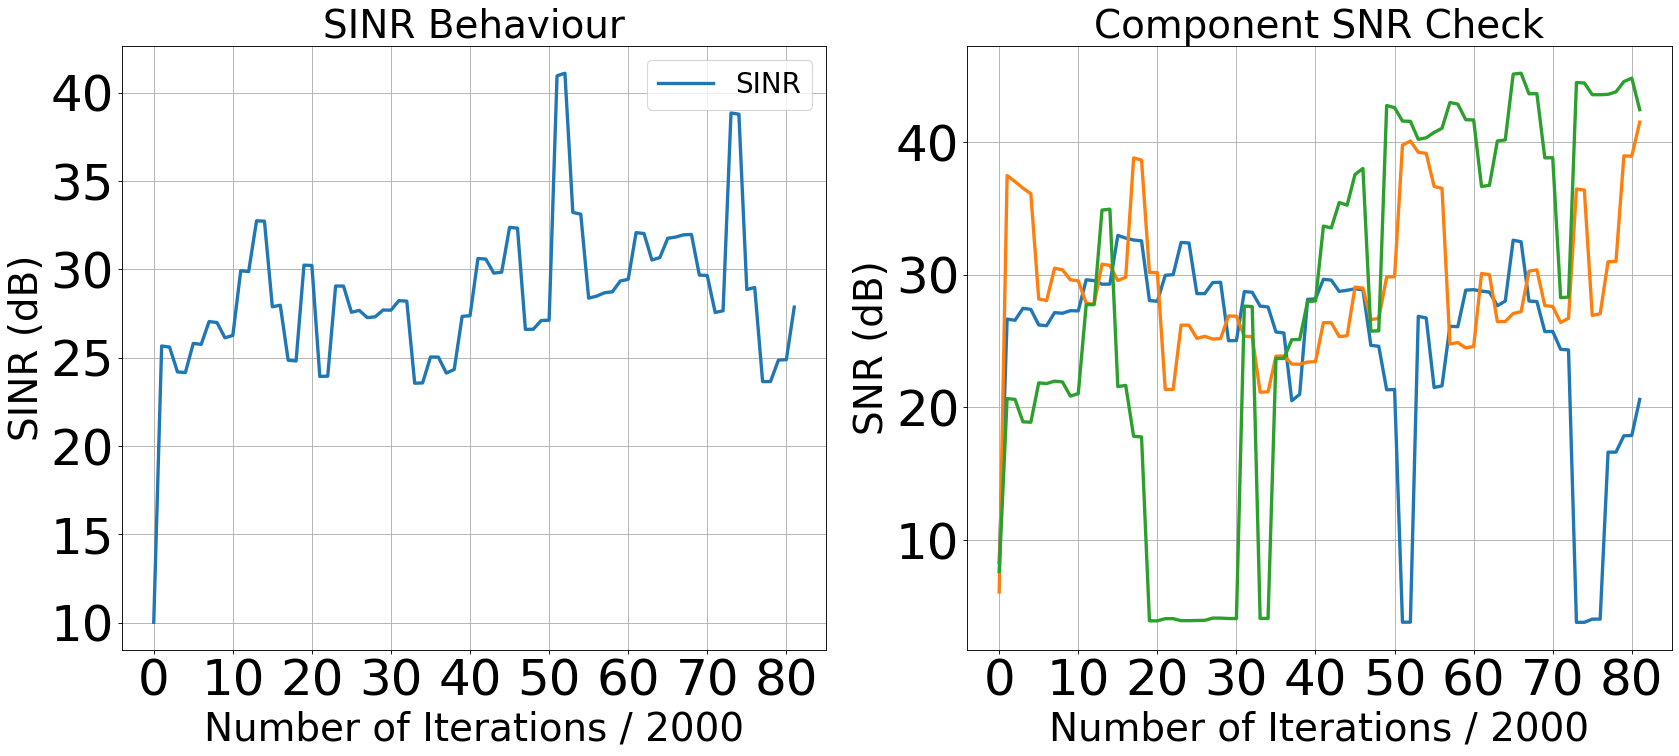

In [9]:
model.fit_batch_nnantisparse(X, batch_size = 10000, epsilon = 1e-5, mu_start = 100, 
                             n_iterations_per_batch = 2000, method = "covariance", 
                             debug_iteration_point = debug_iteration_point,
                             plot_in_jupyter = True)

In [10]:
W = model.W
Y = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
10 * np.log10(CalculateSINR(Y_.T, S)[0])

28.657205964338715

In [11]:
W = model.W
Y_ = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
snr(S.T, Y_)

array([20.60205311, 41.50164131, 42.44020549])

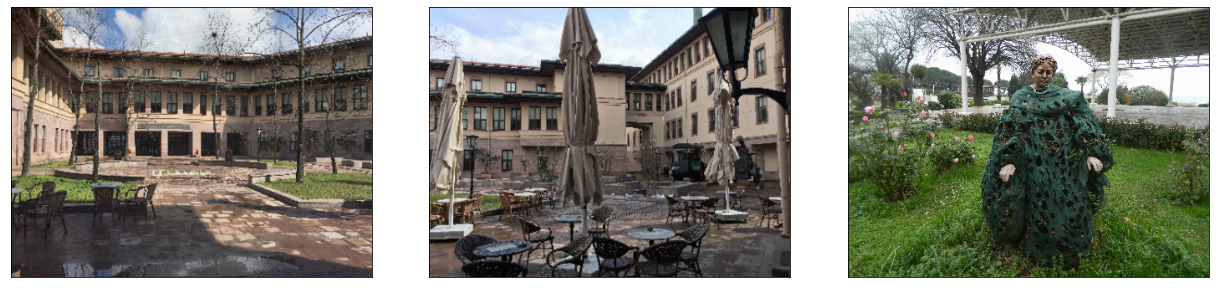

In [12]:
Subplot_RGB_images(ZeroOneNormalizeColumns(Y_).T, imsize = [324,432], height = 4, width = 18)
plt.savefig('ImageSeparationLDMI_Output.pdf', format = 'pdf', dpi = 1500)

In [17]:
def getSystemInfo():
    import platform,socket,re,uuid,json,logging
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
#         info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return info
    except Exception as e:
        print(str(e))

In [18]:
getSystemInfo()

{'platform': 'Linux',
 'platform-release': '3.10.0-693.11.6.el7.x86_64',
 'platform-version': '#1 SMP Thu Jan 4 01:06:37 UTC 2018',
 'architecture': 'x86_64',
 'hostname': 'ai02.kuacc.ku.edu.tr',
 'ip-address': '172.20.242.209',
 'mac-address': 'ac:1f:6b:f5:02:31',
 'processor': 'x86_64'}

In [19]:
import platform

print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

======================================== System Information ========================================
System: Linux
Node Name: ai02.kuacc.ku.edu.tr
Release: 3.10.0-693.11.6.el7.x86_64
Version: #1 SMP Thu Jan 4 01:06:37 UTC 2018
Machine: x86_64
Processor: x86_64


In [24]:
import psutil
import platform
from datetime import datetime
import cpuinfo
import socket
import uuid
import re


def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

def System_information():
    print("="*40, "System Information", "="*40)
    uname = platform.uname()
    print(f"System: {uname.system}")
    print(f"Node Name: {uname.node}")
    print(f"Release: {uname.release}")
    print(f"Version: {uname.version}")
    print(f"Machine: {uname.machine}")
    print(f"Processor: {uname.processor}")
    print(f"Processor: {cpuinfo.get_cpu_info()['brand_raw']}")
    print(f"Ip-Address: {socket.gethostbyname(socket.gethostname())}")
    print(f"Mac-Address: {':'.join(re.findall('..', '%012x' % uuid.getnode()))}")


    # Boot Time
    print("="*40, "Boot Time", "="*40)
    boot_time_timestamp = psutil.boot_time()
    bt = datetime.fromtimestamp(boot_time_timestamp)
    print(f"Boot Time: {bt.year}/{bt.month}/{bt.day} {bt.hour}:{bt.minute}:{bt.second}")


    # print CPU information
    print("="*40, "CPU Info", "="*40)
    # number of cores
    print("Physical cores:", psutil.cpu_count(logical=False))
    print("Total cores:", psutil.cpu_count(logical=True))
    # CPU frequencies
    cpufreq = psutil.cpu_freq()
    print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
    print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
    print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
    # CPU usage
    print("CPU Usage Per Core:")
    for i, percentage in enumerate(psutil.cpu_percent(percpu=True, interval=1)):
        print(f"Core {i}: {percentage}%")
    print(f"Total CPU Usage: {psutil.cpu_percent()}%")


    # Memory Information
    print("="*40, "Memory Information", "="*40)
    # get the memory details
    svmem = psutil.virtual_memory()
    print(f"Total: {get_size(svmem.total)}")
    print(f"Available: {get_size(svmem.available)}")
    print(f"Used: {get_size(svmem.used)}")
    print(f"Percentage: {svmem.percent}%")



    print("="*20, "SWAP", "="*20)
    # get the swap memory details (if exists)
    swap = psutil.swap_memory()
    print(f"Total: {get_size(swap.total)}")
    print(f"Free: {get_size(swap.free)}")
    print(f"Used: {get_size(swap.used)}")
    print(f"Percentage: {swap.percent}%")



    # Disk Information
    print("="*40, "Disk Information", "="*40)
    print("Partitions and Usage:")
    # get all disk partitions
    partitions = psutil.disk_partitions()
    for partition in partitions:
        print(f"=== Device: {partition.device} ===")
        print(f"  Mountpoint: {partition.mountpoint}")
        print(f"  File system type: {partition.fstype}")
        try:
            partition_usage = psutil.disk_usage(partition.mountpoint)
        except PermissionError:
            # this can be catched due to the disk that
            # isn't ready
            continue
        print(f"  Total Size: {get_size(partition_usage.total)}")
        print(f"  Used: {get_size(partition_usage.used)}")
        print(f"  Free: {get_size(partition_usage.free)}")
        print(f"  Percentage: {partition_usage.percent}%")
    # get IO statistics since boot
    disk_io = psutil.disk_io_counters()
    print(f"Total read: {get_size(disk_io.read_bytes)}")
    print(f"Total write: {get_size(disk_io.write_bytes)}")

    ## Network information
    print("="*40, "Network Information", "="*40)
    ## get all network interfaces (virtual and physical)
    if_addrs = psutil.net_if_addrs()
    for interface_name, interface_addresses in if_addrs.items():
        for address in interface_addresses:
            print(f"=== Interface: {interface_name} ===")
            if str(address.family) == 'AddressFamily.AF_INET':
                print(f"  IP Address: {address.address}")
                print(f"  Netmask: {address.netmask}")
                print(f"  Broadcast IP: {address.broadcast}")
            elif str(address.family) == 'AddressFamily.AF_PACKET':
                print(f"  MAC Address: {address.address}")
                print(f"  Netmask: {address.netmask}")
                print(f"  Broadcast MAC: {address.broadcast}")
    ##get IO statistics since boot
    net_io = psutil.net_io_counters()
    print(f"Total Bytes Sent: {get_size(net_io.bytes_sent)}")
    print(f"Total Bytes Received: {get_size(net_io.bytes_recv)}")

In [25]:
System_information()

======================================== System Information ========================================
System: Linux
Node Name: ai02.kuacc.ku.edu.tr
Release: 3.10.0-693.11.6.el7.x86_64
Version: #1 SMP Thu Jan 4 01:06:37 UTC 2018
Machine: x86_64
Processor: x86_64
Processor: Intel(R) Xeon(R) Gold 6248 CPU @ 2.50GHz
Ip-Address: 172.20.242.209
Mac-Address: ac:1f:6b:f5:02:31
======================================== Boot Time ========================================
Boot Time: 2022/7/4 17:44:18
======================================== CPU Info ========================================
Physical cores: 40
Total cores: 40
Max Frequency: 2501.00Mhz
Min Frequency: 1000.00Mhz
Current Frequency: 2250.80Mhz
CPU Usage Per Core:
Core 0: 0.0%
Core 1: 2.0%
Core 2: 100.0%
Core 3: 100.0%
Core 4: 1.0%
Core 5: 100.0%
Core 6: 100.0%
Core 7: 1.0%
Core 8: 1.0%
Core 9: 100.0%
Core 10: 100.0%
Core 11: 100.0%
Core 12: 100.0%
Core 13: 100.0%
Core 14: 100.0%
Core 15: 100.0%
Core 16: 100.0%
Core 17: 100.0%
Core 18: 98.